## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as snb
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib
import warnings

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

## Reading Raw Data & Managing Headers & getting 10/5 percents of dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

In [ ]:
dataset_path = 'my dataset path'

In [6]:
df = pd.read_csv(dataset_path)

In [ ]:
column_names = [
        "my dataset column names",
    ]

df.columns = column_names

In [ ]:
# Get 10% random sample
sample_10_percent = df.sample(frac=0.1, random_state=42)  # random_state for reproducibility

In [ ]:
sample_10_percent.to_csv("path", index=False)

In [ ]:
sample_10_percent.to_excel("path", index=False)

In [ ]:
# Get 5% random sample
sample_5_percent = df.sample(frac=0.05, random_state=42)  # random_state for reproducibility
sample_5_percent.to_csv("path", index=False)
sample_5_percent.to_excel("path", index=False)

## Data Process

In [ ]:
import re
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

# ----------------------------- Defaults -----------------------------

DEFAULT_TARGET_PERSIAN = "risk_score"       # preferred display name
ASCII_TARGET = "target_risk_class"         # ASCII alias for exports

# Strings treated as nulls (case-insensitive applied by adding .upper())
NULL_LIKE_STRINGS = {
    "", " ", "  ", "na", "n/a", "none", "null", "nan", "?", "-", "--"
}
NULL_LIKE_STRINGS |= {s.upper() for s in NULL_LIKE_STRINGS}

# Numeric sentinels treated as missing
SENTINEL_NUMS = {-100, -999, 999999, -1_000_000_000}

# Casting thresholds
NUMERIC_PARSE_THRESHOLD = 0.85
DATETIME_PARSE_THRESHOLD = 0.85

# Outlier capping quantiles
DEFAULT_CAP_LOW = 0.01
DEFAULT_CAP_HIGH = 0.99

# Categorical heuristics
MAX_UNIQUE_ABS = 1000
MAX_UNIQUE_RATIO = 0.50

# Fill value for categoricals
CAT_FILL = "Missing"

# ----------------------------- Utilities -----------------------------

def normalize_ws(x: Any) -> Any:
    """Normalize whitespace, remove ZWNJ/RTL marks, collapse spaces."""
    if isinstance(x, str):
        x = re.sub(r"[\u200c\u200f\u200e]", "", x)     # remove ZWNJ/RTL/LTR marks
        x = x.replace("\u00a0", " ")                   # nbsp to space
        x = re.sub(r"\s+", " ", x).strip()
    return x

def normalize_header(name: str) -> str:
    """Normalization used for matching column names robustly."""
    s = normalize_ws(str(name))
    s = s.lower()
    s = re.sub(r"[_\-\s]+", " ", s).strip()
    return s

def standardize_nulls(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].map(normalize_ws)
            df[c] = df[c].replace(list(NULL_LIKE_STRINGS), np.nan)
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].replace(list(SENTINEL_NUMS), np.nan)
        else:
            df[c] = df[c].replace({str(v): np.nan for v in SENTINEL_NUMS})
    return df

def resolve_target_name(df: pd.DataFrame, preferred: Optional[str]) -> Optional[str]:
    """
    Try to find the target column robustly.
    Prints out possible matches for debugging.
    """
    norm_map: Dict[str, str] = {normalize_header(c): c for c in df.columns}
    print(f"[debug] Column normalization map: {norm_map}")  # Print the normalized columns

    candidates_raw = []
    if preferred:
        candidates_raw.append(preferred)

    # Persian variants (with/without ZWNJ/extra spaces)
    candidates_raw += [
        DEFAULT_TARGET_PERSIAN, "other values",
    ]
    # ASCII/English variants
    candidates_raw += [
        "target_risk_class", "risk_class", "riskcategory", "risk_cat",
        "target", "label", "y", "class", "category",
    ]

    # Add normalized forms
    candidates_norm = [normalize_header(x) for x in candidates_raw]
    print(f"[debug] Candidates to match: {candidates_norm}")  # Print candidates
    for cand in candidates_norm:
        if cand in norm_map:
            print(f"[debug] Matched column: {cand}")
            return norm_map[cand]
    return None

def sanitize_target(df: pd.DataFrame, target_col: Optional[str]) -> Tuple[pd.DataFrame, Optional[str]]:
    """
    If target_col is provided or detected, coerce to Int8 in [1..10] and return (df, target_col).
    If not found, return df unchanged and target_col=None.
    """
    if target_col is None or target_col not in df.columns:
        return df, None
    t = pd.to_numeric(df[target_col], errors="coerce")
    t = t.where((t >= 1) & (t <= 10))
    df = df.copy()
    df[target_col] = t.astype("Int8")
    return df, target_col

def drop_constant_and_duplicate(df: pd.DataFrame, target_col: Optional[str]) -> Tuple[pd.DataFrame, List[str]]:
    """Drop constant columns and duplicate-by-content columns (excluding target)."""
    df = df.copy()
    dropped: List[str] = []

    const_cols = [c for c in df.columns if (target_col is None or c != target_col) and df[c].nunique(dropna=False) <= 1]
    if const_cols:
        df.drop(columns=const_cols, inplace=True, errors="ignore")
        dropped.extend(const_cols)

    seen_hash: Dict[int, str] = {}
    dup_cols: List[str] = []
    for c in df.columns:
        h = pd.util.hash_pandas_object(df[c], index=False).sum()
        if h in seen_hash and (target_col is None or c != target_col):
            dup_cols.append(c)
        else:
            seen_hash[h] = c
    if dup_cols:
        df.drop(columns=dup_cols, inplace=True, errors="ignore")
        dropped.extend(dup_cols)
    return df, dropped

def safe_cast(df: pd.DataFrame, target_col: Optional[str]) -> pd.DataFrame:
    """Cast object columns to numeric/datetime if majority parseable; else keep string."""
    df = df.copy()
    for c in df.columns:
        if target_col is not None and c == target_col:
            continue
        s = df[c]
        if not (s.dtype == object or pd.api.types.is_string_dtype(s)):
            continue
        # numeric try
        if pd.api.types.is_string_dtype(s) or s.dtype == object:
            s_str = s.astype("string")
            num = pd.to_numeric(s_str.str.replace(",", "", regex=False), errors="coerce")
        else:
            num = pd.to_numeric(s, errors="coerce")
        r_num = float(num.notna().mean()) if len(s) else 0.0
        # datetime try
        dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
        r_dt = float(dt.notna().mean()) if len(s) else 0.0

        if r_num >= NUMERIC_PARSE_THRESHOLD and r_num >= r_dt:
            df[c] = num
        elif r_dt >= DATETIME_PARSE_THRESHOLD:
            df[c] = dt
        else:
            df[c] = s.astype("string")
    return df

def cap_outliers(df: pd.DataFrame,
                 target_col: Optional[str],
                 q_low: float = DEFAULT_CAP_LOW,
                 q_high: float = DEFAULT_CAP_HIGH) -> pd.DataFrame:
    """Winsorize numeric columns at given quantiles."""
    df = df.copy()
    for c in df.columns:
        if target_col is not None and c == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            arr = df[c].astype("float64")
            lo = arr.quantile(q_low)
            hi = arr.quantile(q_high)
            df[c] = arr.clip(lo, hi)
    return df

def mark_categoricals(df: pd.DataFrame,
                      target_col: Optional[str],
                      max_unique_abs: int = MAX_UNIQUE_ABS,
                      max_unique_ratio: float = MAX_UNIQUE_RATIO) -> pd.DataFrame:
    """Convert string-like columns to pandas 'category' when cardinality is reasonable."""
    df = df.copy()
    n = max(len(df), 1)
    for c in df.columns:
        if target_col is not None and c == target_col:
            continue
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            k = df[c].nunique(dropna=True)
            if (k <= max_unique_abs) and (k / n <= max_unique_ratio):
                df[c] = df[c].astype("category")
            else:
                df[c] = df[c].astype("string")
    return df

def impute_model_ready(df: pd.DataFrame,
                       target_col: Optional[str],
                       cat_fill: str = CAT_FILL) -> pd.DataFrame:
    """Impute numerics with median; categoricals/strings with constant; datetimes with mode."""
    df = df.copy()
    for c in df.columns:
        if target_col is not None and c == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].fillna(df[c].median(skipna=True))
        elif pd.api.types.is_categorical_dtype(df[c]):
            if cat_fill not in df[c].cat.categories:
                df[c] = df[c].cat.add_categories([cat_fill])
            df[c] = df[c].fillna(cat_fill)
        elif pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].fillna(cat_fill)
        elif pd.api.types.is_datetime64_any_dtype(df[c]):
            mode_val = df[c].mode(dropna=True)
            df[c] = df[c].fillna(mode_val.iloc[0] if not mode_val.empty else pd.NaT)
        else:
            df[c] = df[c].astype("string").fillna(cat_fill)
    return df

def slugify(name: str) -> str:
    s = str(name).strip()
    s = re.sub(r"[^0-9A-Za-z]+", "_", s)
    s = re.sub(r"_{2,}", "_", s).strip("_")
    return (s or "col")[:80]

def make_ascii_mapping(cols: List[str], keep_cols: Optional[List[str]] = None) -> Dict[str, str]:
    keep_cols = set(keep_cols or [])
    mapping: Dict[str, str] = {}
    used = set()
    for c in cols:
        if c in keep_cols:
            continue
        s = slugify(c)
        base = s or "col"
        i = 1
        while s in used:
            s = f"{base}_{i}"
            i += 1
        mapping[c] = s
        used.add(s)
    return mapping

# ----------------------------- Core processing -----------------------------

def process_dataframe(df: pd.DataFrame,
                      target_col: Optional[str],
                      cap: bool = True,
                      q_low: float = DEFAULT_CAP_LOW,
                      q_high: float = DEFAULT_CAP_HIGH,
                      build_ascii: bool = True) -> Dict[str, pd.DataFrame]:
    """Apply full cleaning pipeline and return multiple output variants."""
    df1 = standardize_nulls(df)

    # Resolve and coerce target if present
    df1, tgt = sanitize_target(df1, target_col)

    df1, _ = drop_constant_and_duplicate(df1, tgt)
    df1 = safe_cast(df1, tgt)
    if cap:
        df1 = cap_outliers(df1, tgt, q_low=q_low, q_high=q_high)
    df1 = mark_categoricals(df1, tgt)

    cleaned = df1.copy()
    model_ready = impute_model_ready(cleaned, tgt)

    outputs = {"cleaned_persian": cleaned, "model_ready_persian": model_ready}

    # ASCII variants (rename columns; keep target name as ASCII if present)
    if build_ascii:
        keep_cols = [tgt] if tgt else []
        mapping = make_ascii_mapping(list(model_ready.columns), keep_cols=keep_cols)
        if tgt:
            outputs["cleaned_ascii"] = cleaned.rename(columns={**mapping, tgt: ASCII_TARGET})
            outputs["model_ready_ascii"] = model_ready.rename(columns={**mapping, tgt: ASCII_TARGET})
        else:
            outputs["cleaned_ascii"] = cleaned.rename(columns=mapping)
            outputs["model_ready_ascii"] = model_ready.rename(columns=mapping)
    return outputs

# ----------------------------- Notebook entrypoint -----------------------------

def run_pipeline_csv(df: pd.DataFrame,
                     outdir: str,
                     target_col: Optional[str] = DEFAULT_TARGET_PERSIAN,  # you can set to None to auto-detect
                     target_required: bool = False,                        # set True to enforce presence
                     cap: bool = True,
                     cap_low: float = DEFAULT_CAP_LOW,
                     cap_high: float = DEFAULT_CAP_HIGH,
                     build_ascii: bool = True) -> None:
    """
    Jupyter-safe entrypoint for CSV inputs.
    - If target_col is None, the pipeline will try to auto-detect a likely target name.
    - If target_required=True and the target isn't found in the first chunk, raises KeyError.
    Writes {cleaned_persian, model_ready_persian, cleaned_ascii, model_ready_ascii}.csv to outdir.
    """
    out_dir = Path(outdir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Decide target
    final_target = target_col
    if final_target is None:
        final_target = resolve_target_name(df, preferred=None)

    if target_required and (final_target is None or final_target not in df.columns):
        raise KeyError(f"Missing target column. Looked for '{DEFAULT_TARGET_PERSIAN}' and common variants. "
                       f"Pass target_col='your_column' or set target_required=False.")

    # Process the whole DataFrame
    processed_data = process_dataframe(df, target_col=final_target, cap=cap, q_low=cap_low, q_high=cap_high, build_ascii=build_ascii)

    # Save the outputs to disk
    for name, data in processed_data.items():
        data.to_csv(out_dir / f"{name}.csv", index=False, encoding="utf-8")
        print(f"Saved {name}.csv to {out_dir.resolve()}")

run_pipeline_csv(df, outdir="processed_data_output", target_col="risk_score", target_required=True)

Saved cleaned_persian.csv to /content/processed_data_output
Saved model_ready_persian.csv to /content/processed_data_output
Saved cleaned_ascii.csv to /content/processed_data_output
Saved model_ready_ascii.csv to /content/processed_data_output


In [ ]:
import shutil

local_folder = 'path'
drive_folder = 'path'

shutil.copy(local_folder, drive_folder)

'/content/drive/MyDrive/Thesis Project Final/ML-Classification/model_ready_ascii.csv'

## Checking NULL Values (USE model_ready_ascii.csv FOR ML)

In [ ]:
import pandas as pd 
df = pd.read_csv("path")

In [ ]:
df

In [ ]:
has_nulls = df.isnull().any().any()
print(has_nulls)  # Output: True or False

True


In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

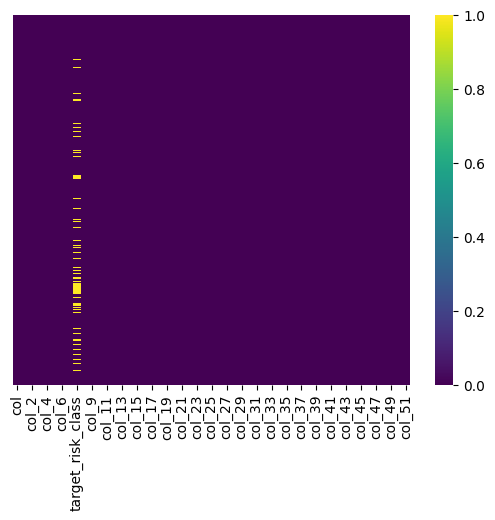

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.show()

In [ ]:
# Getting 5% again of this cleaned dataset

df_sample = df.sample(frac=0.05, random_state=42)  # Exactly 5% random rows
df_sample.to_csv('cleaned_sampled_5_percent.csv', index=False)  # index=False avoids adding row indices as a column
print("Sample saved to 'sampled_5percent.csv'")

Sample saved to 'sampled_5percent.csv'


In [ ]:
df["target_risk_class"].unique()

array([ 1.,  6., nan,  4.,  8.,  7.,  5.,  2.,  9.,  3., 10.])